<a href="https://colab.research.google.com/github/SankalpC10/Colab_Notebooks/blob/main/AVLCC_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Lifetime Value prediction for Kaggle Acquire Valued Customer Challenge

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


def zero_inflated_lognormal_pred(logits: tf.Tensor) -> tf.Tensor:
  """Calculates predicted mean of zero inflated lognormal logits.

  Arguments:
    logits: [batch_size, 3] tensor of logits.

  Returns:
    preds: [batch_size, 1] tensor of predicted mean.
  """
  logits = tf.convert_to_tensor(logits, dtype=tf.float32)
  positive_probs = tf.keras.backend.sigmoid(logits[..., :1])
  loc = logits[..., 1:2]
  scale = tf.keras.backend.softplus(logits[..., 2:])
  preds = (
      positive_probs *
      tf.keras.backend.exp(loc + 0.5 * tf.keras.backend.square(scale)))
  return preds


def zero_inflated_lognormal_loss(labels: tf.Tensor,
                                 logits: tf.Tensor) -> tf.Tensor:
  """Computes the zero inflated lognormal loss.

  Usage with tf.keras API:

  ```python
  model = tf.keras.Model(inputs, outputs)
  model.compile('sgd', loss=zero_inflated_lognormal)
  ```

  Arguments:
    labels: True targets, tensor of shape [batch_size, 1].
    logits: Logits of output layer, tensor of shape [batch_size, 3].

  Returns:
    Zero inflated lognormal loss value.
  """
  labels = tf.convert_to_tensor(labels, dtype=tf.float32)
  positive = tf.cast(labels > 0, tf.float32)

  logits = tf.convert_to_tensor(logits, dtype=tf.float32)
  logits.shape.assert_is_compatible_with(
      tf.TensorShape(labels.shape[:-1].as_list() + [3]))

  positive_logits = logits[..., :1]
  classification_loss = tf.keras.losses.binary_crossentropy(
      y_true=positive, y_pred=positive_logits, from_logits=True)

  loc = logits[..., 1:2]
  scale = tf.math.maximum(
      tf.keras.backend.softplus(logits[..., 2:]),
      tf.math.sqrt(tf.keras.backend.epsilon()))
  safe_labels = positive * labels + (
      1 - positive) * tf.keras.backend.ones_like(labels)
  regression_loss = -tf.keras.backend.mean(
      positive * tfd.LogNormal(loc=loc, scale=scale).log_prob(safe_labels),
      axis=-1)

  return classification_loss + regression_loss

In [ ]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import tqdm
from typing import Sequence
from sklearn.preprocessing import LabelEncoder

# install and import ltv
!pip install -q git+https://github.com/seyedrezamirkhani/lifetime_value
import lifetime_value as ltv

  Preparing metadata (setup.py) ... done


In [ ]:
tfd = tfp.distributions
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None  # default='warn'

## Global variables

In [ ]:
COMPANY = '103600030'  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param { isTemplate: true, type: 'integer'}
OUTPUT_CSV_FOLDER = '/tmp/lifetime-value/kaggle_acquire_valued_shoppers_challenge/result'  # @param { isTemplate: true, type: 'string'}

In [ ]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Data

### Download data

Setup kaggle API correctly following https://www.kaggle.com/docs/api
```
%%shell
mkdir ~/.kaggle
echo \{\"username\":\"{your kaggle username}\",\"key\":\"{your kaggle api key}\"\} > ~/.kaggle/kaggle.json
pip install kaggle
```

In [ ]:
# %%shell
# mkdir ~/.kaggle
# echo \{\"username\":\"sankalpchavhan\",\"key\":\"c2c7e3b5079f84cb89cb3557fbcc2aa2\"\} > ~/.kaggle/kaggle.json
# pip install kaggle

In [ ]:
# %%shell
# if [ -e /tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv ]; then
#   echo "File already exists, no need to download."
# else
#   rm -rf /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   mkdir -p /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   cd /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   kaggle competitions download -c acquire-valued-shoppers-challenge
#   echo "Unzipping the dataset..."
#   unzip acquire-valued-shoppers-challenge.zip
#   if [ -e transactions.csv.gz ]; then
#     gunzip transactions.csv.gz
#   fi
# fi

### Load transaction csv

In [ ]:
def load_transaction_data(company):
  # all_data_filename = '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv'
  # one_company_data_filename = (
  #     '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions_company_{}.csv'
  #     .format(COMPANY))
  # if os.path.isfile(one_company_data_filename):
  #   df = pd.read_csv(one_company_data_filename)
  # else:
  #   data_list = []
  #   chunksize = 10**6
  #   # 350 iterations
  #   for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
  #     data_list.append(chunk.query("company=='{}'".format(company)))
  #   df = pd.concat(data_list, axis=0)
  #   df.to_csv(one_company_data_filename, index=None)
  file_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/CLV/company_df.csv' # To-do: Update

  try:
      company_df = pd.read_csv(file_path)
  except:
    data_list = []
    chunksize = 10**6
    # 350 iterations
    for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
      data_list.append(chunk.query("company=='{}'".format(company)))
    df = pd.concat(data_list, axis=0)
    df.to_csv(one_company_data_filename, index=None)
  return company_df

In [ ]:
load_transaction_data(COMPANY)

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,4634035492,152,26,2634,103600030,4139,2013-04-29,6.0,RL,1,5.69
1,4634035492,152,26,2634,103600030,4139,2013-05-29,6.0,RL,1,5.69
2,4634035492,152,26,2634,103600030,4139,2013-06-18,6.0,RL,1,5.69
3,4634035608,153,26,2630,103600030,9787,2012-03-19,120.0,CT,1,2.19
4,4634035608,153,26,2630,103600030,9787,2012-04-02,120.0,CT,1,2.19
...,...,...,...,...,...,...,...,...,...,...,...
48870,4821703398,46,26,2634,103600030,4139,2013-06-28,6.0,RL,2,4.98
48871,4836226081,46,26,2613,103600030,8583,2013-07-21,98.0,CT,1,24.99
48872,4847628950,166,26,2632,103600030,8583,2013-07-21,216.0,CT,1,5.99
48873,4847628950,166,26,2630,103600030,9787,2013-07-22,255.0,CT,1,3.49


### Preprocess data

In [ ]:
def preprocess(df):
  df = df.query('purchaseamount>0')
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df['start_date'] = df.groupby('id')['date'].transform('min')

  # Compute calibration values
  calibration_value = (
      df.query('date==start_date').groupby('id')
      ['purchaseamount'].sum().reset_index())
  calibration_value.columns = ['id', 'calibration_value']

  # Compute holdout values
  one_year_holdout_window_mask = (
      (df['date'] > df['start_date']) &
      (df['date'] <= df['start_date'] + np.timedelta64(365, 'D')))
  holdout_value = (
      df[one_year_holdout_window_mask].groupby('id')
      ['purchaseamount'].sum().reset_index())
  holdout_value.columns = ['id', 'holdout_value']

  # Compute calibration attributes
  calibration_attributes = (
      df.query('date==start_date').sort_values(
          'purchaseamount', ascending=False).groupby('id')[[
              'chain', 'dept', 'category', 'brand', 'productmeasure'
          ]].first().reset_index())

  # Merge dataframes
  customer_level_data = (
      calibration_value.merge(calibration_attributes, how='left',
                              on='id').merge(
                                  holdout_value, how='left', on='id'))
  customer_level_data['holdout_value'] = (
      customer_level_data['holdout_value'].fillna(0.))
  customer_level_data[CATEGORICAL_FEATURES] = (
      customer_level_data[CATEGORICAL_FEATURES].fillna('UNKNOWN'))

  # Specify data types
  customer_level_data['log_calibration_value'] = (
      np.log(customer_level_data['calibration_value']).astype('float32'))
  customer_level_data['chain'] = (
      customer_level_data['chain'].astype('category'))
  customer_level_data['dept'] = (customer_level_data['dept'].astype('category'))
  customer_level_data['brand'] = (
      customer_level_data['brand'].astype('category'))
  customer_level_data['category'] = (
      customer_level_data['category'].astype('category'))
  customer_level_data['label'] = (
      customer_level_data['holdout_value'].astype('float32'))
  return customer_level_data

### Load customer-level csv

In [ ]:
def load_customer_level_csv(company):
  customer_level_data_file = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/customer_level_data_company_{}.csv'
      .format(company))
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    customer_level_data = preprocess(load_transaction_data(company))
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [ ]:
COMPANY

'103600030'

In [ ]:
# Processes data. 350 iteration in total. May take 10min.
customer_level_data = load_customer_level_csv(COMPANY)

In [ ]:
# # prompt: load csv file from /content/drive/MyDrive/Colab Notebooks/Datasets/CLV/company_df.csv

# import pandas as pd

# # Assuming you have already mounted your Google Drive and the file path is correct.
# file_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/CLV/company_df.csv'

# try:
#     company_df = pd.read_csv(file_path)
#     print("Successfully loaded the CSV file.")
#     # Now you can work with the company_df DataFrame
#     print(company_df.head()) # Display first few rows for verification

# except FileNotFoundError:
#     print(f"Error: File not found at {file_path}")
# except pd.errors.EmptyDataError:
#     print(f"Error: The CSV file at {file_path} is empty.")
# except pd.errors.ParserError:
#     print(f"Error: Unable to parse the CSV file at {file_path}. Check the file format.")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")

In [ ]:
# customer_level_data = company_df

In [ ]:
customer_level_data.head()

,id,calibration_value,chain,dept,category,brand,productmeasure,holdout_value,log_calibration_value,label
0,4634035492,5.69,152,26,2634,4139,RL,11.380000,1.738710,11.380000
1,4634035608,2.19,153,26,2630,9787,CT,63.360001,0.783902,63.360001
2,4634035670,5.49,153,26,2630,9787,CT,259.769989,1.702928,259.769989
3,4634037748,7.50,153,26,2630,9787,CT,3.150000,2.014903,3.150000
4,4634040646,6.29,6,26,2634,4139,RL,52.980000,1.838961,52.980000


We observe a mixture of zero and lognormal distribution of holdout value.

In [ ]:
customer_level_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6822 entries, 0 to 6821
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     6822 non-null   int64   
 1   calibration_value      6822 non-null   float32 
 2   chain                  6822 non-null   category
 3   dept                   6822 non-null   category
 4   category               6822 non-null   category
 5   brand                  6822 non-null   category
 6   productmeasure         6822 non-null   category
 7   holdout_value          6822 non-null   float32 
 8   log_calibration_value  6822 non-null   float32 
 9   label                  6822 non-null   float32 
dtypes: category(5), float32(4), int64(1)
memory usage: 197.3 KB


<Axes: >

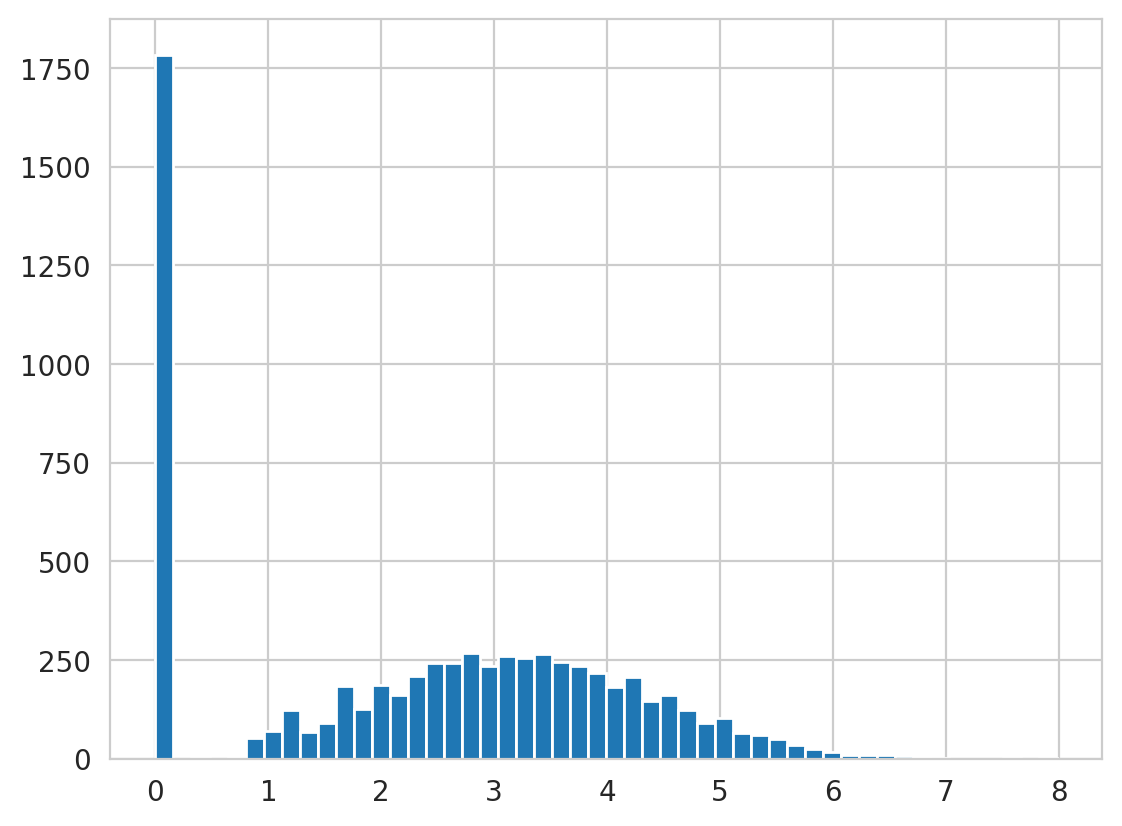

In [ ]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

### Make train/eval

In [ ]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values
  y0 = df['calibration_value'].values

  x_train, x_eval, y_train, y_eval, y0_train, y0_eval = (
      model_selection.train_test_split(
          x, y, y0, test_size=0.2, random_state=123))

  return x_train, x_eval, y_train, y_eval, y0_eval

In [ ]:
def dnn_split(df):
    # Create a dictionary to store encoders for each categorical feature
    encoders = {}

    for key in CATEGORICAL_FEATURES:
        encoders[key] = preprocessing.LabelEncoder()  # Create encoder for this feature
        df[key] = encoders[key].fit_transform(df[key])  # Ensure no +1 here

    y0 = df['calibration_value'].values
    df_train, df_eval, y0_train, y0_eval = model_selection.train_test_split(
        df, y0, test_size=0.2, random_state=123)

    def feature_dict(df):
        features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
        features['numeric'] = df[NUMERIC_FEATURES].values
        return features

    x_train, y_train = feature_dict(df_train), df_train['label'].values

    # Transform x_eval using the encoders fitted on the training data
    x_eval_transformed = {}
    for key in CATEGORICAL_FEATURES:
        x_eval_transformed[key] = encoders[key].transform(df_eval[key])
    x_eval_transformed['numeric'] = df_eval[NUMERIC_FEATURES].values
    x_eval = x_eval_transformed

    y_eval = df_eval['label'].values

    return x_train, x_eval, y_train, y_eval, y0_eval

## Model

In [ ]:
def linear_model(output_units):
  return tf.keras.experimental.LinearModel(output_units)

In [ ]:
def embedding_dim(x):
  return int(x**.25) + 1

def embedding_layer(vocab_size):
    return tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=vocab_size+1,  # +1 to include 0 index
            output_dim=embedding_dim(vocab_size)
        ),
        tf.keras.layers.Flatten(),
    ])

def dnn_model(output_units, df):
    numeric_input = tf.keras.layers.Input(shape=(len(NUMERIC_FEATURES),), name='numeric')

    embedding_inputs = [
        tf.keras.layers.Input(shape=(1,), name=key, dtype='int64')  # Changed dtype to 'int64'
        for key in CATEGORICAL_FEATURES
    ]

    embedding_outputs = [
        embedding_layer(vocab_size=70)(input) #To-do: Update
        for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
    ]

    # Concatenate all inputs (numeric + embeddings)
    deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)

    # Sequential dense layers for the deep model
    x = tf.keras.layers.Dense(64, activation='relu')(deep_input)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(output_units)(x)  # Final layer

    return tf.keras.Model(inputs=[numeric_input] + embedding_inputs, outputs=x)

### Train

In [ ]:
if LOSS == 'mse':
  loss = keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [ ]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval, y0_eval = linear_split(customer_level_data)
  model = linear_model(output_units)

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval, y0_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

In [ ]:
y_train = y_train.reshape(-1, 1)
y_eval = y_eval.reshape(-1, 1)

In [ ]:
print(f"y_train shape: {y_train.shape}")
print(f"y_eval shape: {y_eval.shape}")
print(f"logits shape (model output): {model.output_shape}")

y_train shape: (5457, 1)
y_eval shape: (1365, 1)
logits shape (model output): (None, 3)


In [ ]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [ ]:
for key in CATEGORICAL_FEATURES:
    print(f"{key} max value after encoding: {customer_level_data[key].max()}")

chain max value after encoding: 67
dept max value after encoding: 3
category max value after encoding: 13
brand max value after encoding: 10
productmeasure max value after encoding: 2


In [ ]:
for key in CATEGORICAL_FEATURES:
    print(f"{key} vocab size: {customer_level_data[key].nunique()}")

chain vocab size: 68
dept vocab size: 4
category vocab size: 14
brand vocab size: 11
productmeasure vocab size: 3


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Epoch 1/400
6/6 - 4s - 744ms/step - loss: 13.7016 - val_loss: 12.8975 - learning_rate: 2.0000e-04
Epoch 2/400
6/6 - 0s - 25ms/step - loss: 12.5314 - val_loss: 11.9194 - learning_rate: 2.0000e-04
Epoch 3/400
6/6 - 0s - 23ms/step - loss: 11.5765 - val_loss: 11.0997 - learning_rate: 2.0000e-04
Epoch 4/400
6/6 - 0s - 48ms/step - loss: 10.7801 - val_loss: 10.4256 - learning_rate: 2.0000e-04
Epoch 5/400
6/6 - 0s - 28ms/step - loss: 10.1227 - val_loss: 9.8498 - learning_rate: 2.0000e-04
Epoch 6/400
6/6 - 0s - 49ms/step - loss: 9.5637 - val_loss: 9.3671 - learning_rate: 2.0000e-04
Epoch 7/400
6/6 - 0s - 51ms/step - loss: 9.1031 - val_loss: 8.9623 - learning_rate: 2.0000e-04
Epoch 8/400
6/6 - 0s - 48ms/step - loss: 8.7141 - val_loss: 8.6203 - learning_rate: 2.0000e-04
Epoch 9/400
6/6 - 0s - 49ms/step - loss: 8.3872 - val_loss: 8.3294 - learning_rate: 2.0000e-04
Epoch 10/400
6/6 - 0s - 29ms/step - loss: 8.1057 - val_loss: 8.0684 - learning_rate: 2.0000e-04
Epoch 11/400
6/6 - 0s - 28ms/step - los

<Axes: >

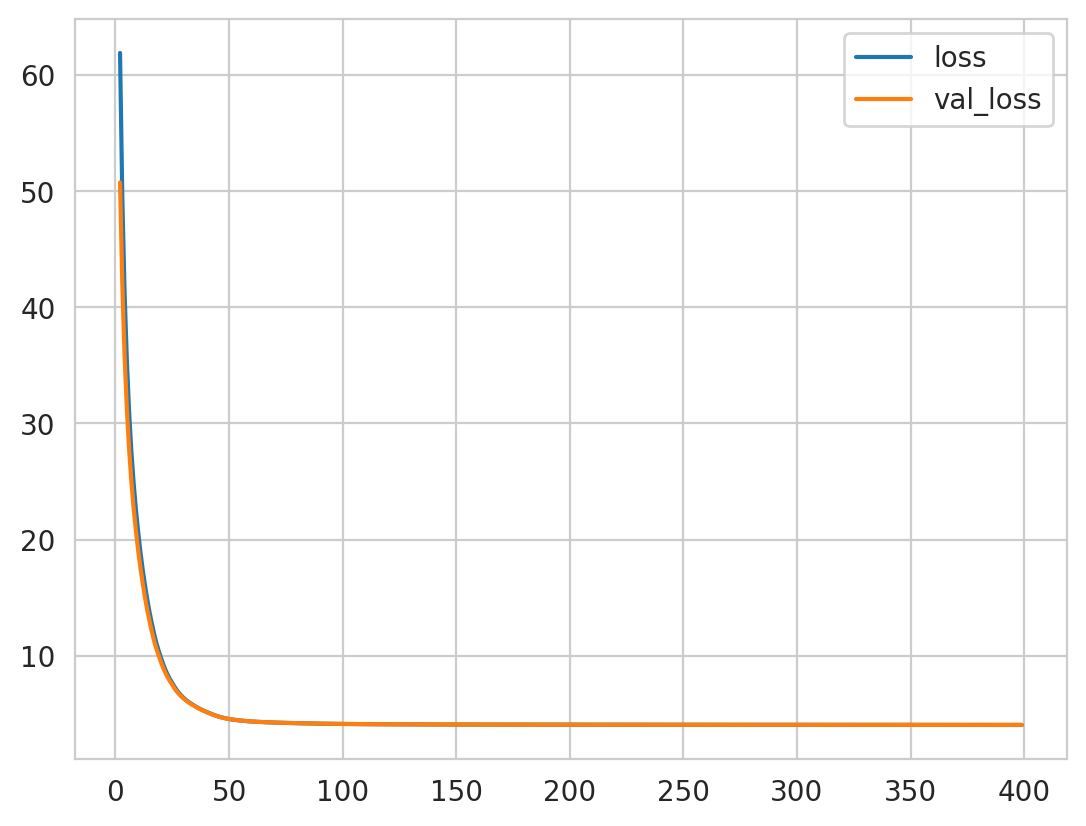

In [ ]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

### Eval

In [ ]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


In [ ]:
x_eval

{'chain': array([31, 32, 32, ..., 13, 31, 32]),
 'dept': array([1, 1, 1, ..., 1, 1, 1]),
 'category': array([8, 8, 4, ..., 8, 4, 8]),
 'brand': array([4, 4, 5, ..., 4, 5, 4]),
 'productmeasure': array([0, 0, 0, ..., 0, 0, 0]),
 'numeric': array([[1.8484548 ],
        [0.37156355],
        [1.943049  ],
        ...,
        [2.0122328 ],
        [1.2499018 ],
        [0.32930374]], dtype=float32)}

In [ ]:
y_eval

array([[ 6.58],
       [11.05],
       [ 0.  ],
       ...,
       [ 0.  ],
       [ 9.48],
       [ 6.63]], dtype=float32)

In [ ]:
y_pred.max()

119.20236

In [ ]:
y_pred

array([27.310705, 20.268429, 26.846546, ...,  6.084929, 25.035564,
       20.26843 ], dtype=float32)

In [ ]:
df_pred = pd.DataFrame({
    'y_true': y_eval.flatten(),  # Ensure y_eval is a 1D array
    'y_pred': y_pred
})

# Display the first 10 rows
print(df_pred.head(10))

       y_true     y_pred
0    6.580000  27.310705
1   11.050000  20.268429
2    0.000000  26.846546
3   12.700000  24.194239
4  243.619995  43.856449
5   12.890000  42.037209
6  116.279999  80.154335
7   52.340000  27.081429
8   25.860001  43.366383
9   78.400002  75.181801


### Gini Coefficient

In [ ]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval.flatten(), y_eval.flatten()),  # Ensure y_eval is 1D
    'baseline': ltv.cumulative_true(y_eval.flatten(), y0_eval.flatten()),  # Ensure y0_eval is 1D
    'model': ltv.cumulative_true(y_eval.flatten(), y_pred.flatten()),  # Ensure y_pred is 1D
})


In [ ]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

Text(0.5, 1.0, 'Gain Chart')

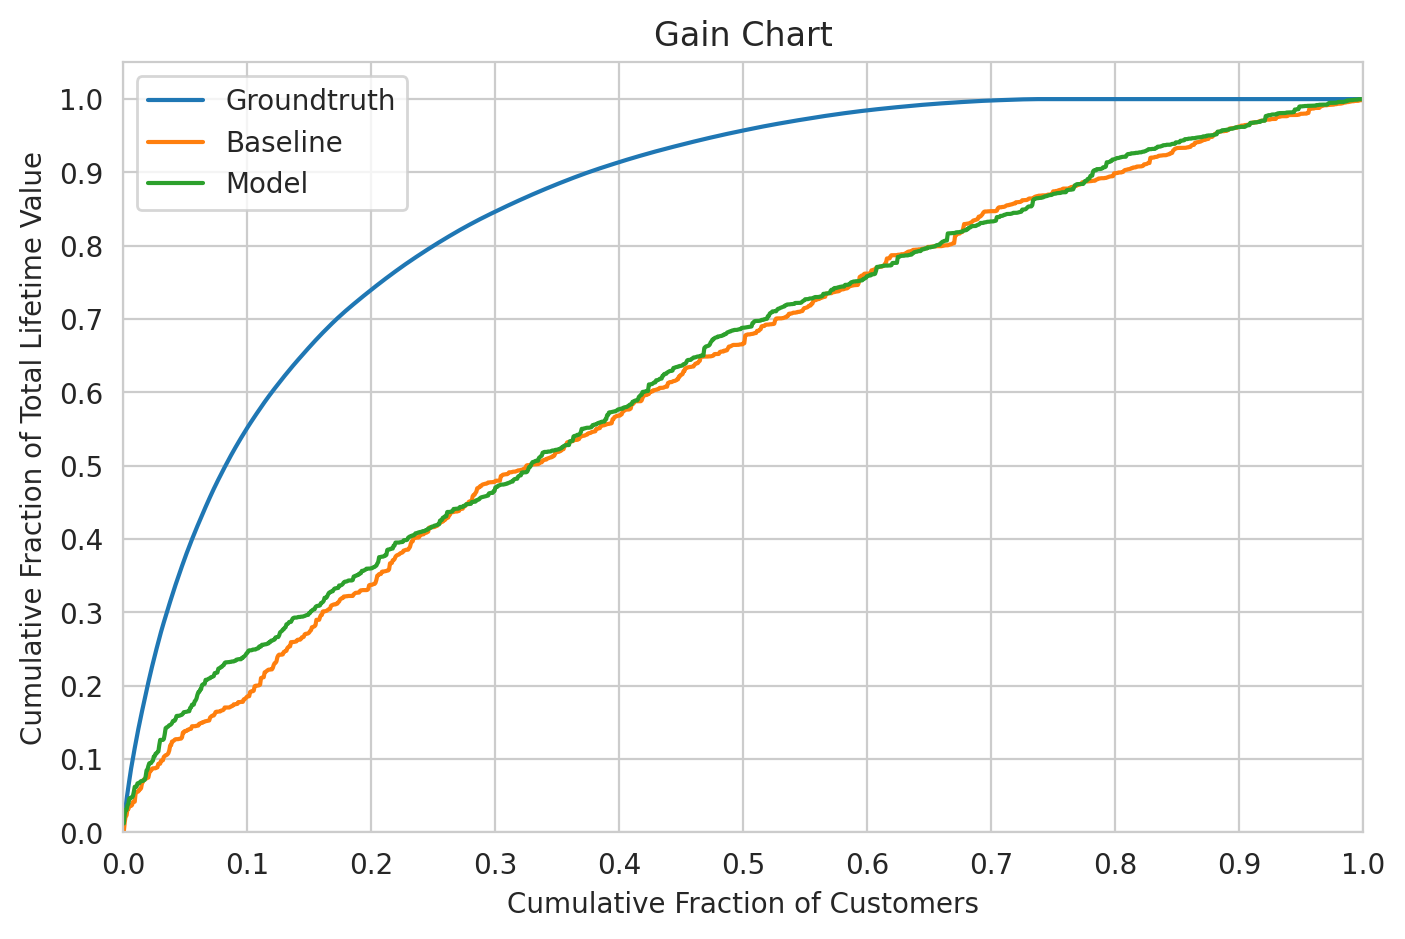

In [ ]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='upper left')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart')

In [ ]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

/usr/local/lib/python3.10/dist-packages/lifetime_value/metrics.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized = raw / raw[0]


,raw,normalized
lorenz,0.717520,1.000000
baseline,0.252049,0.351278
model,0.272249,0.379430


### Calibration

In [ ]:
df_decile = ltv.decile_stats(y_eval.flatten(), y_pred)
df_decile

/usr/local/lib/python3.10/dist-packages/lifetime_value/metrics.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('decile').apply(_aggregate_fn)


,label_mean,pred_mean,normalized_rmse,normalized_mae,decile_mape
decile,,,,,
0,14.694230,13.119066,2.404859,1.175367,0.107196
1,21.054737,20.264040,1.844551,1.025724,0.037554
2,28.910463,24.007492,1.879078,1.025630,0.169592
3,27.225304,26.927282,2.145761,1.081183,0.010946
4,26.125237,30.342936,1.601044,1.129077,0.161442
5,41.193256,35.096962,1.678987,0.900529,0.147993
6,40.330677,40.788692,1.517619,1.022892,0.011357
7,38.182713,48.687038,1.654153,1.171624,0.275107
8,43.615986,58.487907,1.270513,1.098149,0.340974


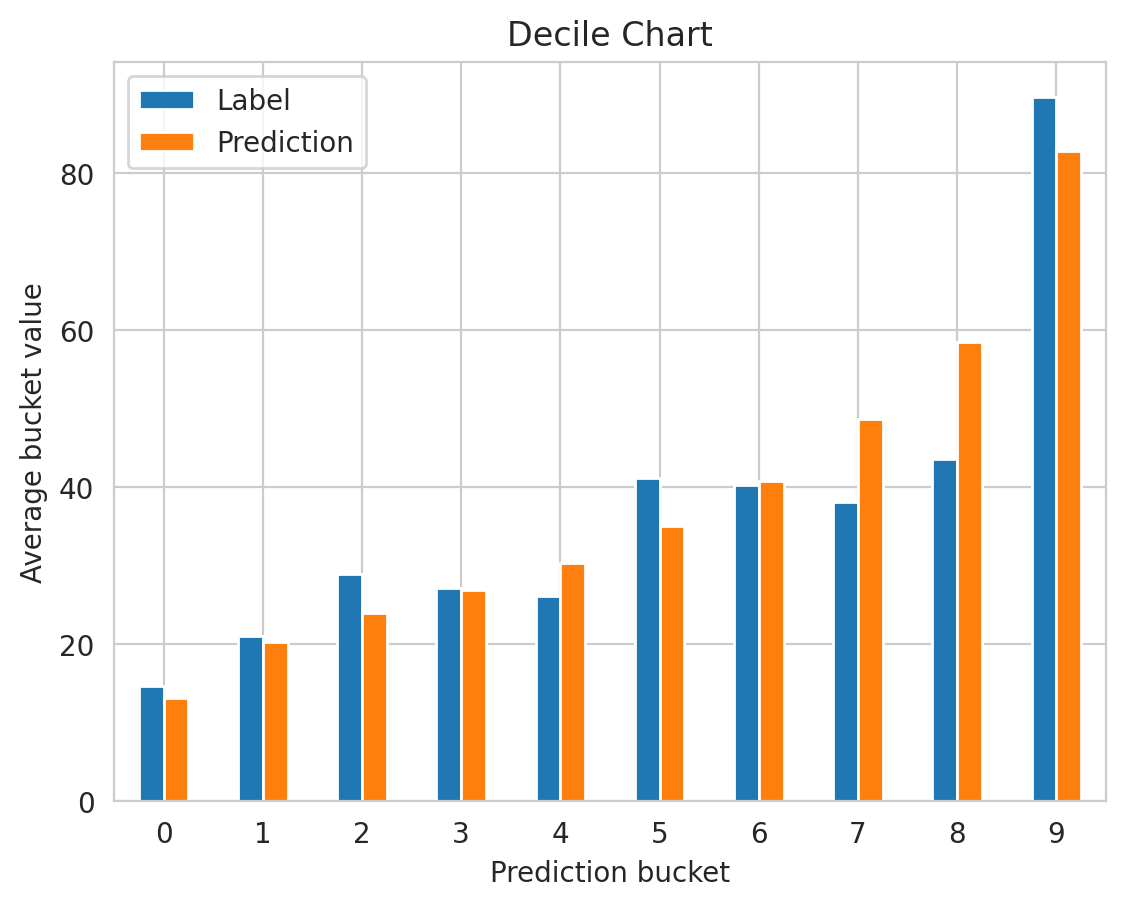

In [ ]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left')

### Rank Correlation

In [ ]:
def spearmanr(x1: Sequence[float], x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

0.2830247363063762

### All metrics together

In [ ]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_eval.mean(),
        'pred_mean': y_pred.mean(),
        'label_positive': np.mean(y_eval > 0),
        'decile_mape': df_decile['decile_mape'].mean(),
        'baseline_gini': gini['normalized'][1],
        'gini': gini['normalized'][2],
        'spearman_corr': spearman_corr,
    },
    index=[0])

<ipython-input-55-c1a784d2a184>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'baseline_gini': gini['normalized'][1],
<ipython-input-55-c1a784d2a184>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'gini': gini['normalized'][2],


In [ ]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'label_positive',
    'decile_mape',
    'baseline_gini',
    'gini',
    'spearman_corr',
]]

,company,model,loss,label_mean,pred_mean,label_positive,decile_mape,baseline_gini,gini,spearman_corr
0,103600030,dnn,ziln,36.734615,37.463535,0.735531,0.133879,0.351278,0.37943,0.283025


## Save

In [ ]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, COMPANY)

In [ ]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [ ]:
output_file = os.path.join(output_path,
                           '{}_regression_{}.csv'.format(MODEL, LOSS))

In [ ]:
df_metrics.to_csv(output_file, index=False)

In [ ]:
def predict_ltv(input_data, model, encoders):

    # Define feature configurations
    CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
    NUMERIC_FEATURES = ['log_calibration_value']

    # Convert input to DataFrame if it's a dictionary
    if isinstance(input_data, dict):
        input_df = pd.DataFrame(input_data)
    elif isinstance(input_data, pd.DataFrame):
        input_df = input_data.copy()
    else:
        raise ValueError("Input must be a dictionary or pandas DataFrame")

    # Prepare categorical features
    x_input_transformed = {}
    for key in CATEGORICAL_FEATURES:
        # Use the pre-fitted encoder to transform categorical features
        x_input_transformed[key] = encoders[key].transform(input_df[key])

    # Prepare numeric features
    x_input_transformed['numeric'] = input_df[NUMERIC_FEATURES].values

    print(x_input_transformed)

    # Make prediction
    predictions = model.predict(x_input_transformed)

    # If using zero-inflated log-normal loss, extract the mean prediction
    if predictions.shape[1] > 1:
        return predictions[:, 0]

    return predictions

def prepare_encoders(df):
    # Define categorical features
    CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']

    # Create a dictionary to store encoders for each categorical feature
    encoders = {}

    for key in CATEGORICAL_FEATURES:
        encoders[key] = LabelEncoder()
        encoders[key].fit(df[key])

    return encoders

# Example usage:
# Assuming 'customer_level_data' is your original preprocessed DataFrame
encoders = prepare_encoders(customer_level_data)
#
sample_input = {
    'chain': [10],
    'dept': [1],
    'category': [8],
    'brand': [4],
    'productmeasure': [2],
    'log_calibration_value': [5.0]
}

ltv_prediction = predict_ltv(sample_input, model, encoders)
print("Predicted LTV:", ltv_prediction)

{'chain': array([10]), 'dept': array([1]), 'category': array([8]), 'brand': array([4]), 'productmeasure': array([2]), 'numeric': array([[5.]])}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Predicted LTV: [0.39061046]


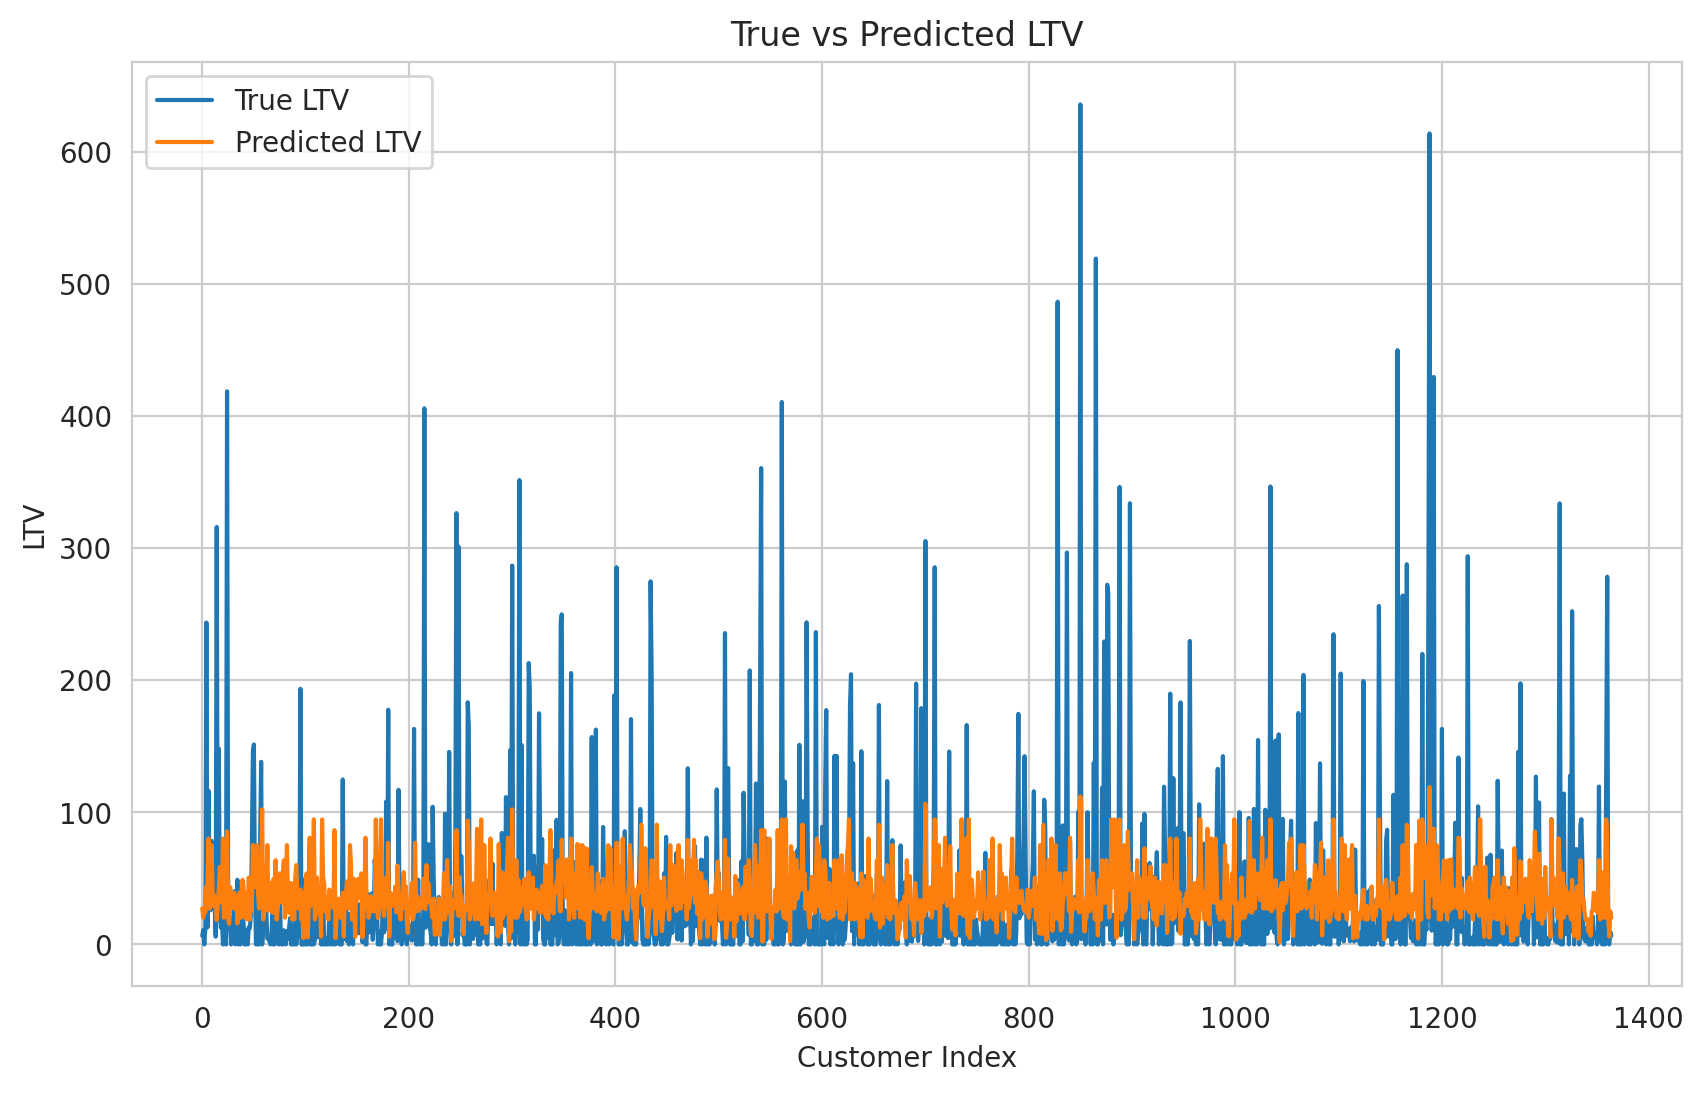

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_pred['y_true'], label='True LTV')
plt.plot(df_pred['y_pred'], label='Predicted LTV')
plt.xlabel('Customer Index')
plt.ylabel('LTV')
plt.title('True vs Predicted LTV')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: check how dnn split is written, then I want to create a predict_ltv function

def predict_ltv(input_data, model, encoders):
    """Predicts lifetime value (LTV) for new customer data.

    Args:
        input_data: A dictionary or pandas DataFrame containing customer data.
        model: The trained TensorFlow/Keras model.
        encoders: A dictionary of LabelEncoders fitted on the training data.

    Returns:
        A NumPy array of predicted LTV values.
    """

    # Define feature configurations (ensure consistency with training data)
    CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
    NUMERIC_FEATURES = ['log_calibration_value']

    # Convert input to DataFrame if it's a dictionary
    if isinstance(input_data, dict):
        input_df = pd.DataFrame(input_data)
    elif isinstance(input_data, pd.DataFrame):
        input_df = input_data.copy()
    else:
        raise ValueError("Input must be a dictionary or pandas DataFrame")

    # Prepare categorical features using the provided encoders
    x_input_transformed = {}
    for key in CATEGORICAL_FEATURES:
        try:
            x_input_transformed[key] = encoders[key].transform(input_df[key])
        except ValueError as e:
            # Handle cases where the input data contains unseen categories
            print(f"Warning: {e}. Replacing unseen categories with 'UNKNOWN' encoding.")
            # You might need to adjust the 'UNKNOWN' handling based on your specific needs
            input_df[key] = input_df[key].astype(str).replace({val: 'UNKNOWN' for val in input_df[key].unique() if val not in encoders[key].classes_})
            x_input_transformed[key] = encoders[key].transform(input_df[key])


    # Prepare numeric features
    x_input_transformed['numeric'] = input_df[NUMERIC_FEATURES].values

    # Make prediction
    predictions = model.predict(x_input_transformed)

    # If using zero-inflated log-normal loss, extract the mean prediction
    if LOSS == 'ziln' and predictions.shape[1] > 1:
      return predictions[:, 0]

    return predictions

In [ ]:
sample_input = {
    'chain': [10],
    'dept': [1],
    'category': [8],
    'brand': [4],
    'productmeasure': [2],
    'log_calibration_value': [5.0]
}

ltv_prediction = predict_ltv(sample_input, model, encoders)
print("Predicted LTV:", ltv_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted LTV: [0.58505046]
